In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import re

In [2]:
pd.set_option('display.max_rows', 20)
np.set_printoptions(threshold = np.inf)

In [3]:
# データロード
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [4]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
# データの総数
print(f"データ数: {len(train_data)}")

# 各カラムのnullの数をカウント
null_counts = train_data.isnull().sum()
print("カラム名    nullの数")
print(null_counts)

データ数: 891
カラム名    nullの数
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [6]:
# インデックスと目的変数
filter_column = ['PassengerId', 'Survived']

# 各カラムのデータ型を取得
column_dtypes = train_data.drop(columns = filter_column).dtypes
print("カラム名    変数型")
print(column_dtypes, '\n')

# float型のカラムのみ抽出
float_columns = column_dtypes[column_dtypes == 'float'].index.tolist()
print(f'float型のカラム: {float_columns}')

# float型以外のカラムのみを抽出
categorical_columns = column_dtypes[column_dtypes != 'float'].index.tolist()
print(f'float型以外のカラム: {categorical_columns}')

カラム名    変数型
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object 

float型のカラム: ['Age', 'Fare']
float型以外のカラム: ['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked']


In [7]:
# 目的変数とのピアソン相関(高い相関 → データ間に関係がある)
float_columns += ['Survived']
train_data[float_columns].corr()

,Age,Fare,Survived
Age,1.000000,0.096067,-0.077221
Fare,0.096067,1.000000,0.257307
Survived,-0.077221,0.257307,1.000000


In [8]:
"""
カイ二乗検定は、観測された度数と期待される度数のずれを評価する統計手法です。
データが独立かどうか調べる → p値が小さい → 独立ではない(データ間に関係がある？)
"""
from scipy.stats import chi2_contingency

# クロステーブルの作成
chi2_results = []
for col in categorical_columns:
    cross_table = pd.crosstab(train_data[col], train_data['Survived'])
    chi2, p, _, _ = chi2_contingency(cross_table) # カイ二乗検定の実行(カイ二乗統計量, p値, 自由度, 期待度数)
    chi2_results.append((col, p))

# p値が小さい順に並べる
print(f"変数名,  p値")
sorted_chi2_results = sorted(chi2_results, key = lambda x:x[1])
sorted_chi2_results

変数名,  p値


[('Sex', np.float64(1.197357062775565e-58)),
 ('Pclass', np.float64(4.549251711298793e-23)),
 ('SibSp', np.float64(1.5585810465902147e-06)),
 ('Embarked', np.float64(1.769922284120912e-06)),
 ('Parch', np.float64(9.703526421039997e-05)),
 ('Ticket', np.float64(0.011527296011637753)),
 ('Cabin', np.float64(0.18357354976388165)),
 ('Name', np.float64(0.484248151973633))]

/var/folders/st/jqtns5g15kqgs2ds4qh0z7240000gn/T/ipykernel_81038/2597443981.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x = "Sex", y = "Survived", data = train_data, palette = palette_custom, errorbar = None)


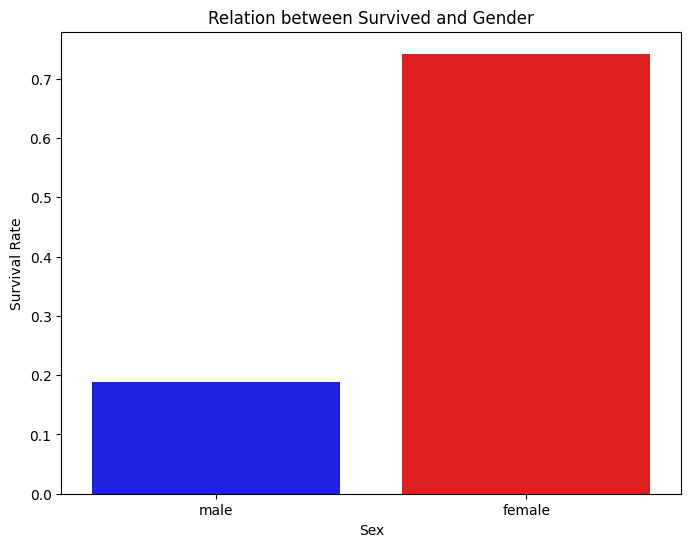

In [9]:
# 'Survived'と'Sex'の関係を可視化
import seaborn as sns

palette_custom = {'male': 'blue', 'female': 'red'}
plt.figure(figsize = (8, 6))
g = sns.barplot(x = "Sex", y = "Survived", data = train_data, palette = palette_custom, errorbar = None)
g.set_title("Relation between Survived and Gender")
g.set_ylabel("Survival Rate")
plt.show()

/var/folders/st/jqtns5g15kqgs2ds4qh0z7240000gn/T/ipykernel_81038/774782749.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x = "Pclass", y = "Survived", data = train_data, palette = "Set1", errorbar = None)


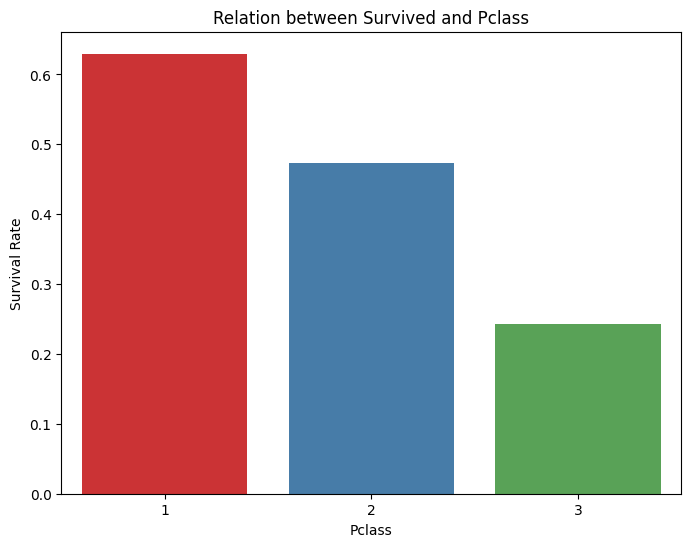

In [10]:
# 'Survived'と'Pclass'の関係を可視化
import seaborn as sns

# palette_custom = {'male': 'blue', 'female': 'red'}
plt.figure(figsize = (8, 6))
g = sns.barplot(x = "Pclass", y = "Survived", data = train_data, palette = "Set1", errorbar = None)
g.set_title("Relation between Survived and Pclass")
g.set_ylabel("Survival Rate")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 決定木の学習
data = train_data

# 欠損値の処理
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

# カテゴリ変数を数値に変換
label_encoders = {}
for column in ['Sex', 'Embarked']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# 今回はName, Ticket, Cabinを削除する
#（カテゴリカル変数として種類が多いのでOne-Hotエンコーディングすると生成される特徴量の数が多すぎるので）
data = data.drop(columns = ['Name', 'Ticket', 'Cabin'])

# データの分割
X = data.drop(columns = ['Survived', 'PassengerId'])
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# 決定木モデルのトレーニング
clf = RandomForestClassifier(random_state = 42, max_depth = 5)
clf.fit(X_train, y_train)

# トレーニングスコア
train_score = clf.score(X_train, y_train)
# バリデーションスコア
test_score = clf.score(X_test, y_test)

print('accuracy train: ', train_score)
print('accuracy validation: ',test_score)

accuracy train:  0.8567415730337079
accuracy validation:  0.8156424581005587


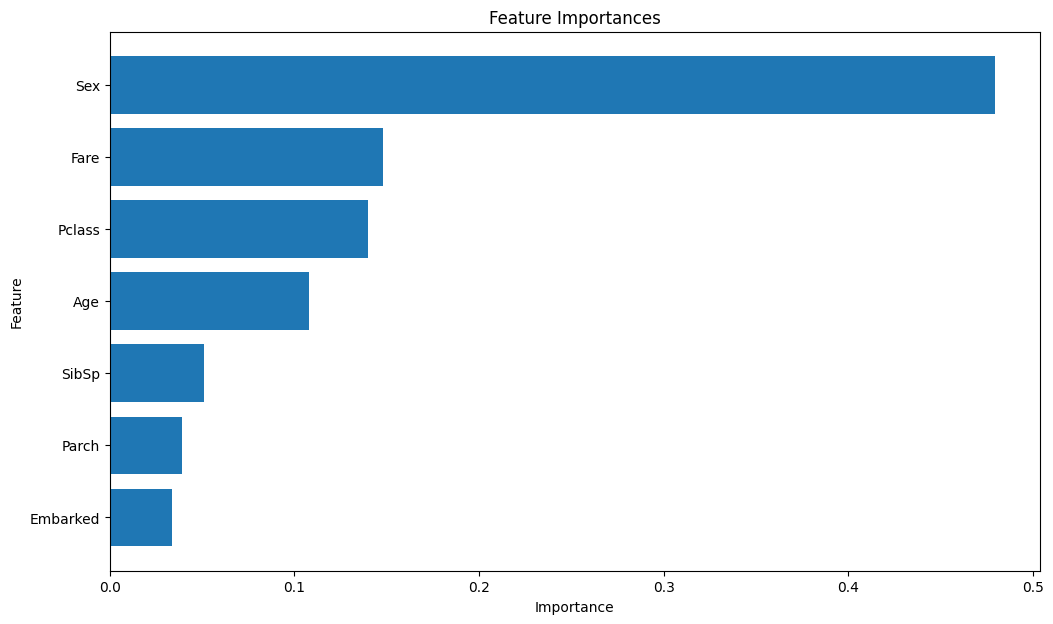

,Feature,Importance
0,Sex,0.479707
1,Fare,0.147958
2,Pclass,0.139716
3,Age,0.108085
4,SibSp,0.051284
5,Parch,0.039289
6,Embarked,0.033960


In [12]:
# 特徴量の重要度を取得
feature_importances = clf.feature_importances_

# 特徴量とその重要度をDataFrameに格納
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# 降順にソート
features_df = features_df.sort_values(by = 'Importance', ascending = False)

# プロット
plt.figure(figsize = (12, 7))
plt.barh(features_df['Feature'], features_df['Importance'], align = 'center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # 上位の特徴量を上に表示
plt.show()

features_df.reset_index(drop = True)

In [13]:
from sklearn.linear_model import Lasso

# Lasso Regressionの学習
data = train_data

# 欠損値の処理
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

# カテゴリ変数を数値に変換
label_encoders = {}
for column in ['Sex', 'Embarked', 'Name']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# 今回はName, Ticket, Cabinを削除する
#（カテゴリカル変数として種類が多いのでOne-Hotエンコーディングすると生成される特徴量の数が多すぎるので）
data = data.drop(columns = ['Name', 'Cabin', 'Ticket'])

# データの分割
X = data.drop(columns = ['Survived', 'PassengerId'])
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# データのスケーリング（標準化）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lasso回帰のトレーニング
lasso = Lasso(alpha = 0.01, random_state = 42)  # 小さなalphaを使用して、多くの特徴量が選択されるようにします。
lasso.fit(X_train_scaled, y_train)

from sklearn.metrics import accuracy_score

# Lassoによる予測
train_preds = lasso.predict(X_train_scaled)
test_preds = lasso.predict(X_test_scaled)

# 予測値を0または1に変換
train_preds = [1 if pred >= 0.5 else 0 for pred in train_preds]
test_preds = [1 if pred >= 0.5 else 0 for pred in test_preds]

# 正解率の計算
lasso_train_accuracy = accuracy_score(y_train, train_preds)
lasso_test_accuracy = accuracy_score(y_test, test_preds)

print('accuracy train: ', lasso_train_accuracy)
print('accuracy validation: ',lasso_test_accuracy)

accuracy train:  0.7921348314606742
accuracy validation:  0.7821229050279329


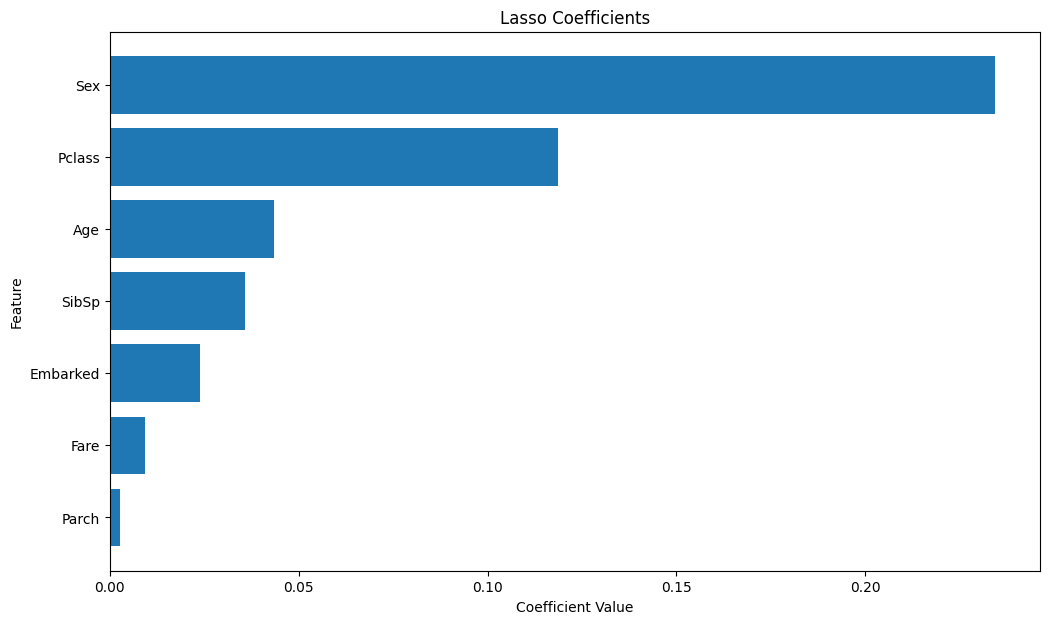

,Feature,Coefficient,AbsCoefficient
0,Sex,-0.234487,0.234487
1,Pclass,-0.118640,0.118640
2,Age,-0.043532,0.043532
3,SibSp,-0.035860,0.035860
4,Embarked,-0.023865,0.023865
5,Fare,0.009427,0.009427
6,Parch,-0.002657,0.002657


In [14]:
# 特徴量の係数
lasso_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
}).sort_values(by = 'Coefficient', ascending = False)

# 特徴量の係数の絶対値を取得してソート
lasso_coefficients['AbsCoefficient'] = lasso_coefficients['Coefficient'].abs()
lasso_coefficients_sorted = lasso_coefficients.sort_values(by = 'AbsCoefficient', ascending = False)

# プロット
plt.figure(figsize = (12, 7))
plt.barh(lasso_coefficients_sorted['Feature'], lasso_coefficients_sorted['AbsCoefficient'], align = 'center')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Lasso Coefficients')
plt.gca().invert_yaxis()  # 上位の特徴量を上に表示
plt.show()

lasso_coefficients.sort_values(by = 'AbsCoefficient', ascending = False).reset_index(drop = True)

## Name(Title)

In [21]:
# データロード
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

train_data[['Name']].head(10)

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"
5,"Moran, Mr. James"
6,"McCarthy, Mr. Timothy J"
7,"Palsson, Master. Gosta Leonard"
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)"
9,"Nasser, Mrs. Nicholas (Adele Achem)"


In [23]:
train_data['Title'] = train_data['Name'].str.split(',', expand = True)[1].str.split('.', expand = True)[0] # expand = Trueとすると、分割した列を新たなカラムとして保持
train_data['Title'].head(10)

0         Mr
1        Mrs
2       Miss
3        Mrs
4         Mr
5         Mr
6         Mr
7     Master
8        Mrs
9        Mrs
Name: Title, dtype: object

In [24]:
print(train_data['Title'].unique())

[' Mr' ' Mrs' ' Miss' ' Master' ' Don' ' Rev' ' Dr' ' Mme' ' Ms' ' Major'
 ' Lady' ' Sir' ' Mlle' ' Col' ' Capt' ' the Countess' ' Jonkheer']


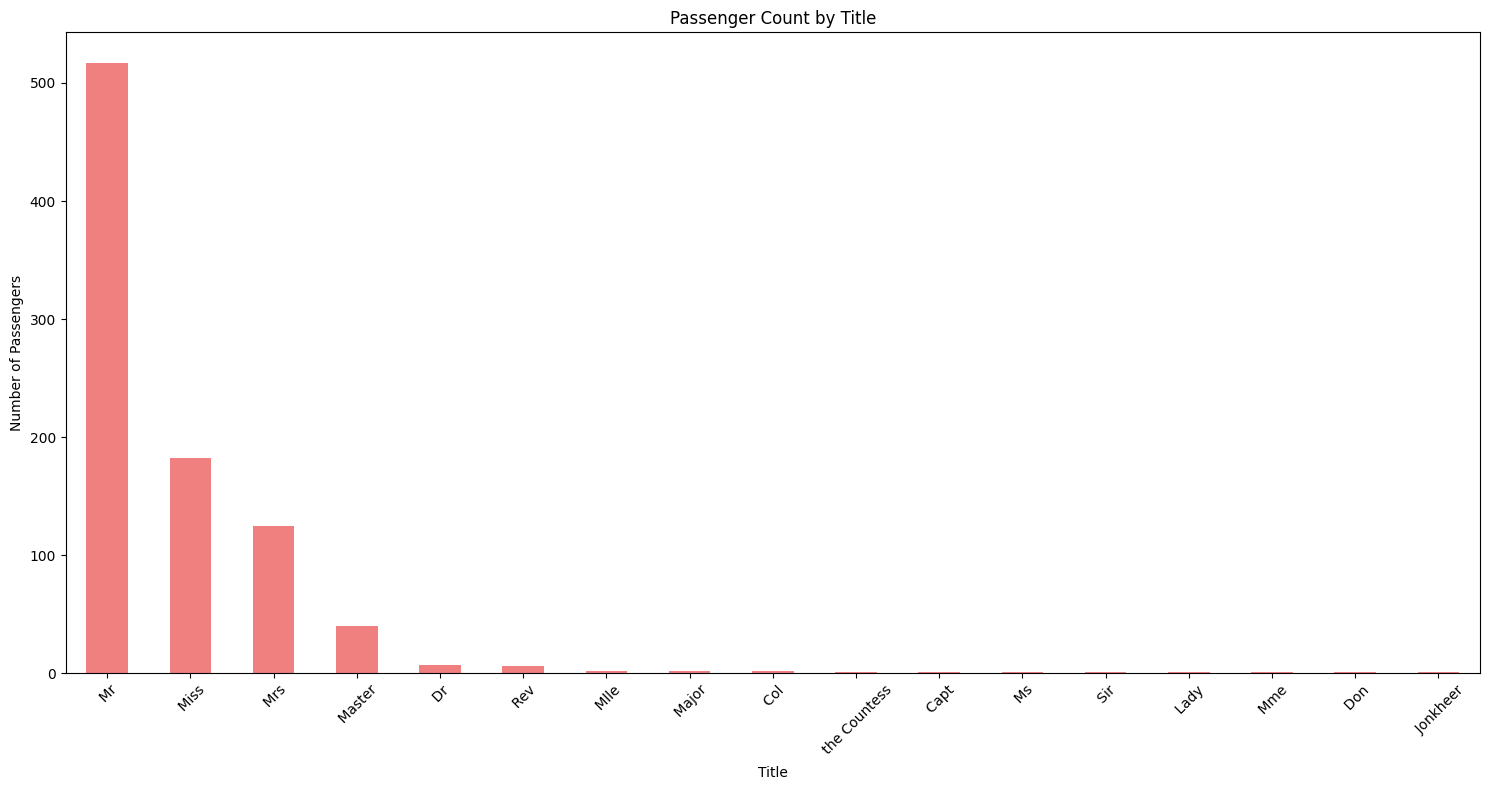

In [25]:
# Titleごとのカウント
title_counts = train_data['Title'].value_counts()

# グラフでTitleのカウントを表示
plt.figure(figsize = (15, 8))
title_counts.plot(kind = 'bar', color = 'lightcoral')
plt.title('Passenger Count by Title')
plt.ylabel('Number of Passengers')
plt.xlabel('Title')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

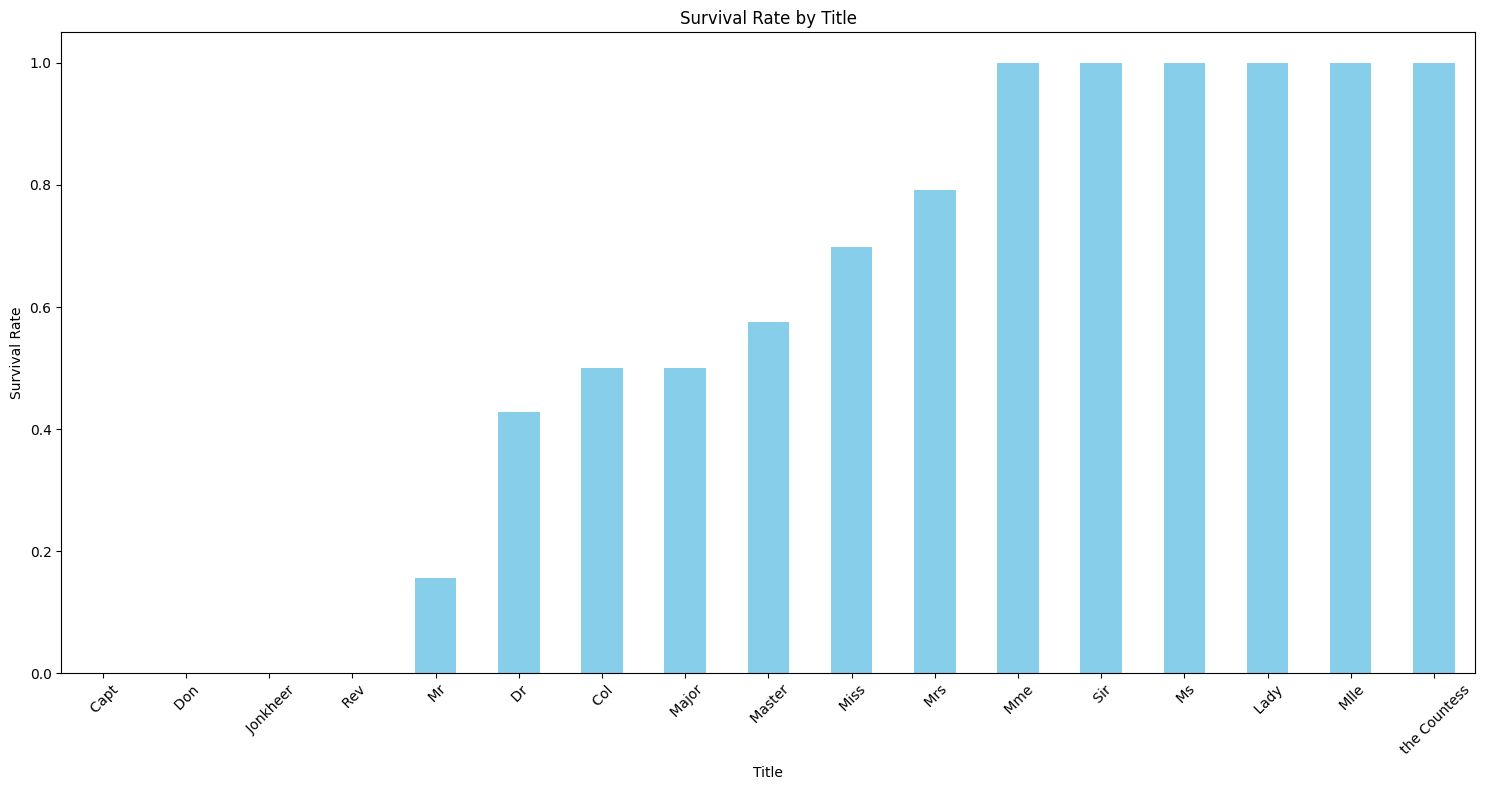

In [26]:
# TitleとSurvivedの関係を集計
title_survival = train_data.groupby('Title')['Survived'].mean().sort_values()

# グラフの描画
plt.figure(figsize = (15, 8))
title_survival.plot(kind = 'bar', color = 'skyblue')
plt.title('Survival Rate by Title')
plt.ylabel('Survival Rate')
plt.xlabel('Title')
plt.xticks(rotation = 45)
plt.tight_layout()


## Ticket

In [ ]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
train_data['Ticket']

### 同じチケット番号(数値部分)の数

In [29]:
ticket_counts = train_data.groupby('Ticket').count()[['PassengerId']]
# ticket_counts
unique_ticket_values = ticket_counts['PassengerId'].unique()


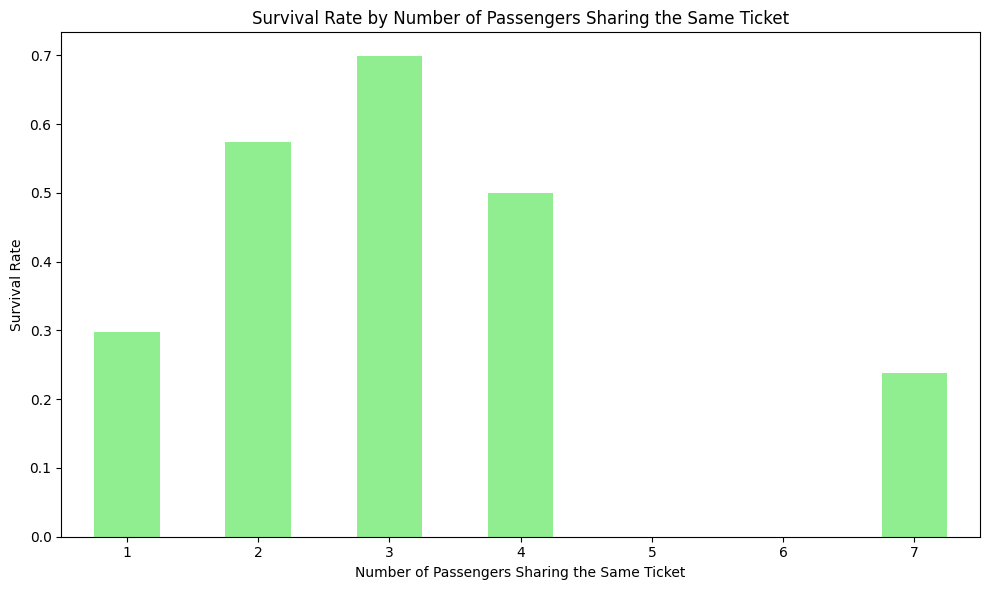

In [35]:
# 恋人と一緒？友達と一緒？メイドと一緒？
# ユニークなカウントごとのSurvivedの平均を計算
# train_data.groupby('Ticket')['PassengerId'].transform('size') [=dfとする] で得られるSeriesをtrain_dataにaxis = 0でconcatして、dfの値ごとにまとめる
unique_ticket_survival_rate = train_data.groupby(train_data.groupby('Ticket')['PassengerId'].transform('size'))['Survived'].mean()

# グラフでユニークなカウントごとのSurvivedの平均を表示
plt.figure(figsize = (10, 6))
unique_ticket_survival_rate.plot(kind='bar', color='lightgreen')
plt.title('Survival Rate by Number of Passengers Sharing the Same Ticket')
plt.ylabel('Survival Rate')
plt.xlabel('Number of Passengers Sharing the Same Ticket')
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()

### チケットの文字列部分

## Cabin

In [ ]:
# データロード
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [ ]:
train_data[['Cabin']]

In [ ]:
def extract_alpha_from_prefix(cabins):
    if pd.isna(cabins):
        return cabins

    alpha_part = ""
    for cabin in cabins.split(' '):
        for char in cabin:
            if char.isalpha():
                alpha_part += char
            else:
                break

    for i in range(len(alpha_part)-1):
        if alpha_part[i] != alpha_part[i+1]:
            return alpha_part

    return alpha_part[0]

In [ ]:
def extract_number_from_prefix(cabins):
    if pd.isna(cabins):
        return cabins

    total = 0
    size = 0
    cabins = cabins.split(' ')
    for cabin in cabins:
        cabin = re.sub(r'[A-Z]', '', cabin)
        if cabin != '':
            total += int(cabin)
            size += 1

    if size == 0:
        return None
    return total / size

### 客室区画

In [ ]:
train_data['Segment'] = train_data['Cabin'].apply(extract_alpha_from_prefix)
train_data['Cabin'].unique()

In [ ]:
segment_count = train_data['Segment'].value_counts()

plt.figure(figsize = (15, 8))
segment_count.plot(kind = 'bar', color = 'lightcoral')
plt.title('Passenger Count by Segment')
plt.ylabel('Number of Passengers')
plt.xlabel('Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# SegmentとSurvivedの関係を集計
train_data['Segment'] = train_data['Segment'].replace(['B', 'BB','BBB', 'BBBB'], 'B')
train_data['Segment'] = train_data['Segment'].replace(['C', 'CC','CCC'], 'C')
train_data['Segment'] = train_data['Segment'].replace(['D', 'DD'], 'D')
segment_survival = train_data.groupby('Segment')['Survived'].mean().sort_values()

# グラフの描画
plt.figure(figsize = (15, 8))
segment_survival.plot(kind = 'bar', color = 'skyblue')
plt.title('Survival Rate by Segment')
plt.ylabel('Survival Rate')
plt.xlabel('Segmnet')
plt.xticks(rotation = 0)
plt.tight_layout()

### 客室番号

In [ ]:
train_data['Segment_number'] = train_data['Cabin'].apply(extract_number_from_prefix)
train_data['Segment_number'].unique()

In [ ]:
segment_number_count = train_data['Segment_number'].value_counts()

plt.figure(figsize = (15, 8))
segment_number_count.plot(kind = 'bar', color = 'lightcoral')
plt.title('Passenger Count by Segment_number')
plt.ylabel('Number of Passengers')
plt.xlabel('Segment_number')
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

In [ ]:
# Segment_numberとSurvivedの関係を集計
segment_number_survival = train_data.groupby('Segment_number')['Survived'].mean()#.sort_values()

# グラフの描画
plt.figure(figsize = (15, 8))
segment_number_survival.plot(kind = 'bar', color = 'skyblue')
plt.title('Survival Rate by Segment_number')
plt.ylabel('Survival Rate')
plt.xlabel('Segmnet_number')
plt.xticks(rotation = 90)
plt.tight_layout()

## まとめ

In [ ]:
# データロード
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [ ]:
def eda(df_all):
    # 3.1.1 Name -> Title
    df_all['Title'] = df_all['Name'].str.split(',', expand = True)[1].str.split('.', expand = True)[0].str.strip()

    # 出現回数が非常に少ないタイトルは過学習の原因になるので、似ている特性でカテゴライズする
    # Miss、Mrs、Ms、Mlle、Lady、Mme、The Countess、Donaはすべて女性であるため、Miss/Mrs/Msに置き換える
    df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
    df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

    # 3.1.2 Ticket -> Ticket Frequency
    df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

    # Cabin -> Segment
    df_all['Segment'] = df_all['Cabin'].apply(extract_alpha_from_prefix)

    # 特徴量同士を組み合わせる
    df_all['Family'] = df_all['SibSp'] + df_all['Parch']
    return df_all

def transform_data_with_eda(data):
    # 欠損値の処理(fillna関数のinplace = Trueは、PandasのDataFrameやSeriesのメソッドで使用される引数で、元のDataFrameまたはSeriesを直接変更することを指定)
    data['Age'].fillna(data['Age'].median(), inplace = True)
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)
    data['Fare'].fillna(data['Fare'].median(), inplace = True)

    # 特徴量の部分抽出
    data = eda(data)
    remove_columns = ['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']
    data = data.drop(columns = remove_columns)
    data_columns = data.columns.tolist()
    data_index = data.index

    # カテゴリ変数を数値に変換
    # LabelEncodeing(カテゴリ変数が特定の順番を持つ場合)
    label_encoders = {}
    le_columns = ['Embarked', 'Segment']
    for column in le_columns:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le

    # OneHotEncoding(カテゴリ変数が特定の順番を持たない場合)
    ohe_columns = ['Sex', 'Title']
    ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), ohe_columns)], remainder = 'passthrough')
    data = ct.fit_transform(data)

    encoded_feature_names = ct.named_transformers_['encoder'].get_feature_names_out(ohe_columns) # OneHotEncoderによって生成された新しい列名を取得
    passthrough_columns = [col for col in data_columns if col not in ohe_columns] # remainder='passthrough' でそのまま通過した列の名前を取得
    all_feature_names = list(encoded_feature_names) + passthrough_columns
    data = pd.DataFrame(data, columns = all_feature_names, index = data_index)

    # 整数型に戻したいカラムのリストを定義
    int_columns = ['PassengerId', 'Survived']
    for col in int_columns:
        if col in data.columns:
            data[col] = data[col].astype(int)

    return data

In [ ]:
train_data = transform_data_with_eda(train_data)
test_data = transform_data_with_eda(test_data)

## 学習

In [ ]:
X = train_data.drop(columns = ['Survived', 'PassengerId'])
y = train_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# --- フィーチャースケーリング ---
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# --- モデルの訓練 ---
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state = 0)
classifier.fit(X_train, y_train)

# トレーニングスコア
train_score = classifier.score(X_train, y_train)

# バリデーションスコア
test_score = classifier.score(X_test, y_test)

print('accuracy train: ', train_score)
print('accuracy validation: ',test_score)

## 提出用

In [ ]:
# データロード
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

# データの前処理
train_data = transform_data_with_eda(train_data)
test_data = transform_data_with_eda(test_data)
X_train = train_data.drop(columns = ['Survived', 'PassengerId'])
y_train = train_data['Survived']
X_test = test_data.drop(columns = ['PassengerId'])

# --- フィーチャースケーリング ---
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# --- モデルの訓練 ---
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state = 0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
X_test_passengerid = test_data['PassengerId'].values

survived_passenger = pd.DataFrame({
    'PassengerId': X_test_passengerid,
    'Survived': y_pred
})
survived_passenger.to_csv('./data/submittion_randomforest2.csv', index = False, encoding = 'utf-8')